# MiniProject 2
Group 31: Frida-Cecilia Acosta-Parenteau, Karl Michel Koerich, Simon Nakane Marcil

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
import urllib.request
import io
import seaborn as sns

%matplotlib inline                                  
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# used for dataset feature extraction
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif
# used for comparison purposes only
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from scipy.sparse import csr_matrix

np.random.seed(1234)

## 20 news group dataset
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

*   Classes:                    20
*   Samples total:           18846
*   Dimensionality:              1
*   Features:                 text

In [2]:
twenty_train = datasets.fetch_20newsgroups_vectorized(remove=(['headers', 'footers', 'quotes']))
print(twenty_train['data'].shape)

twenty_train = datasets.fetch_20newsgroups(remove=(['headers', 'footers', 'quotes'])) # subset='train' by defaul

(11314, 101631)


Feature extraction of 20 newsgroups

In [3]:
# exclude english stop_words and frequencies less than 2
count_vect = CountVectorizer(stop_words='english', min_df=2)

twenty_train_counts = count_vect.fit_transform(twenty_train['data'])
print("Occurrence size: ", twenty_train_counts.shape)

# get frequencies instead of occurences
tf_transformer = TfidfTransformer()

twenty_train_tf = tf_transformer.fit_transform(twenty_train_counts)
print("Frequency size: ", twenty_train_tf.shape)

Occurrence size:  (11314, 39115)
Frequency size:  (11314, 39115)


Train and test data

In [4]:
x_twenty, y_twenty = twenty_train_tf, twenty_train['target']

# print the feature shape and classes of dataset 
(N,D), C = x_twenty.shape, np.max(y_twenty)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_twenty_train, y_twenty_train = x_twenty[inds[:10000]], y_twenty[inds[:10000]]
x_twenty_test, y_twenty_test = x_twenty[inds[10000:]], y_twenty[inds[10000:]]

instances (N) 	 11314 
 features (D) 	 39115 
 classes (C) 	 20


## Sentiment 140 dataset
The data is a CSV with emoticons removed. Data file format has 6 fields:

0.  the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1.  the id of the tweet (2087)
2.  the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3.  the query (lyx). If there is no query, then this value is NO_QUERY.
4.  the user that tweeted (robotickilldozr)
5.  the text of the tweet (Lyx is cool)

http://help.sentiment140.com/for-students

In [5]:
# extract dataset from file
senti_df_train= pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1')

senti_df_train.columns =['Class1', 'ID', 'date', 'NO_QUERY', 'user', "text_train"]
senti_df_train.drop(labels=['ID','date','NO_QUERY', 'user'],axis=1, inplace=True)
dummies=pd.get_dummies(senti_df_train['Class1'])
dummies.columns=["negative=1", "Class_train"]

merged=pd.concat([dummies,senti_df_train], axis='columns')
merged.drop(labels=["negative=1", "Class1"], axis=1, inplace=True)

count= merged["Class_train"]

X_train=merged["text_train"]
Y_train=merged["Class_train"]

[799999, 800000]


<BarContainer object of 2 artists>

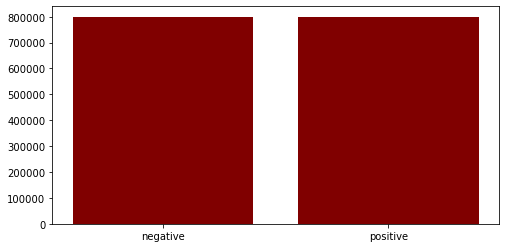

In [6]:
# display count for classes
fig = plt.figure(figsize = (8, 4))
die_or_live = ['negative', 'positive']
arr = merged["Class_train"].astype(np.int64)
counts = [np.count_nonzero(arr == 0), np.count_nonzero(arr == 1)]
print(counts)
plt.bar(die_or_live, counts, color ='maroon')

#### Test set 

(358,)
(358,)
[177, 181]


<BarContainer object of 2 artists>

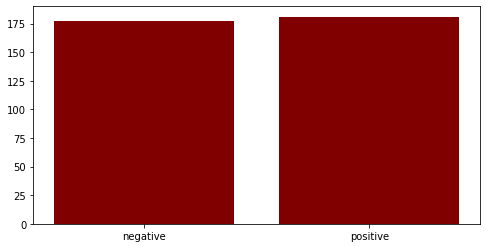

In [7]:
senti_test=pd.read_csv("testdata.manual.2009.06.14.csv", encoding='latin-1')

# california_housing_test.c sv
senti_test.columns =['Class1', 'ID', 'date', 'NO_QUERY', 'user', "text_test"]
senti_test.drop(labels=['ID','date','NO_QUERY', 'user'],axis=1, inplace=True)

array = [0,4]
senti_test=senti_test.loc[senti_test["Class1"].isin(array)]

dummies=pd.get_dummies(senti_test['Class1'])
dummies.columns=["negative=1", "Class_test"]
merged=pd.concat([dummies,senti_test], axis='columns')

merged.drop(labels=["negative=1", "Class1"], axis=1, inplace=True)

X_test=merged["text_test"]
print(X_test.shape)
Y_test=merged["Class_test"]
print(Y_test.shape)

# print count after reduction
fig = plt.figure(figsize = (8, 4))
die_or_live = ['negative', 'positive']
arr = merged["Class_test"].astype(np.int64)
counts = [np.count_nonzero(arr == 0), np.count_nonzero(arr == 1)]
print(counts)
plt.bar(die_or_live, counts, color ='maroon')

Use this as test and train sparce matrices

In [8]:
count_vect = CountVectorizer(stop_words='english', min_df=5, max_df=0.5)
x_train_matrix = count_vect.fit_transform(X_train)
x_test_matrix = count_vect.transform(X_test)

In [9]:
selector = SelectPercentile(f_classif, percentile=20)
selector.fit(x_train_matrix, Y_train)
x_train_matrix_new = selector.transform(x_train_matrix)
x_test_matrix_new= selector.transform(x_test_matrix)

In [10]:
print(x_train_matrix_new.shape, x_train_matrix.shape)

(1599999, 16315) (1599999, 81577)


#### Change the vectors to represent frequencies with TFIDF

In [11]:
tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_matrix)
X_train_tf = tf_transformer.transform(x_train_matrix)
X_test_tf= tf_transformer.transform(x_test_matrix)

X_train_tf.shape, X_test_tf.shape

((1599999, 81577), (358, 81577))

# Naive Bayes

In [12]:
class GaussianNaiveBayes:
    
    def __init__(self, var_smoothing=1e-15):
        self.var_smoothing = var_smoothing
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                         # slice all the elements from class c
            Nc[c] = x_c.shape[0]                    # get number of elements of class c
            mu[c,:] = np.mean(x_c)                  # mean of features of class c
            sigma[c,:] = self.__stdv(x_c, axis=0)   # std of features of class c
            
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        # Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self
    
    # Taken from https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    def __variance(self, a, axis=None):
        """ Variance of sparse matrix a
        var = mean(a**2) - mean(a)**2
        """
        a_squared = a.copy()
        a_squared.data **= 2
        return a_squared.mean(axis) - np.square(a.mean(axis))

    # Taken from https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    def __stdv(self, a, axis=None):
        """ Standard deviation of sparse matrix a
        std = sqrt(var(a))
        """
        return np.sqrt(self.__variance(a, axis))
    
    def __logsumexp(self, Z):                   # dimension C x N
        
        Zmax = np.max(Z,axis=0)
        Zmax = np.expand_dims(Zmax, axis=0) # max over C
        log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
        return log_sum_exp

    def predict(self, xt):
        
        print("xt.shape:", xt.shape)
        Nt, D = xt.shape
        
        # for numerical stability we work in the log domain
        # we add a dimension because this is added to the log-likelihood matrix 
        # that assigns a likelihood for each class (C) to each test point, and so it is C x N
        log_prior = np.log(self.pi)
        log_prior = np.expand_dims(log_prior, axis=1)
        print("log_prior.shape:", log_prior.shape)
        
        # from: https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/naive_bayes.py#L406
        # if the ratio of data variance between dimensions is too small, it
        # will cause numerical errors. To address this, we artificially
        # boost the variance by epsilon
        
        # convert from sparse to dense
        self.sigma = csr_matrix(self.sigma)
        self.sigma = self.sigma.todense()
        self.sigma = np.expand_dims(self.sigma, axis=1)
        self.sigma = self.sigma + self.var_smoothing # boosting by epsilon
        print("self.sigma.shape:", self.sigma.shape)
        
        self.mu = csr_matrix(self.mu)
        self.mu = self.mu.todense()
        self.mu = np.expand_dims(self.mu, axis=1)
        print("self.mu.shape", self.mu.shape)
        
        xt = csr_matrix(xt)
        xt = xt.todense()
        xt = np.expand_dims(xt, axis=0)
        print("xt.shape:", xt.shape)
        
        # logarithm of the likelihood term for Gaussian 
        # the first two terms are the logarithm of the normalization term in the Gaussian and
        # the final term is the exponent in the Gaussian. 
        # Notice that we are adding dimensions (using None) to model parameters and data to make
        # this evaluation. The reason is that sigma and mu are C x D, while the data x is N x D.
        # We operate on a C x N x D shape by increasing the number of dimensions when needed
        
        log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma) -.5 * (((xt - self.mu)/self.sigma)**2)
        
        # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood
        # for each class-test point combination)
        
        log_likelihood = np.sum(log_likelihood, axis=2)
        
        # posterior calculation
        log_posterior = log_prior + log_likelihood
        print("log_posterior.shape:", log_posterior.shape)
        posterior = np.exp(log_posterior - self.__logsumexp(log_posterior))
        
        return posterior.T       # dimension N x C

# Logistic (softmax) regression
from scikit-learn package

# k-fold cross validation

In [13]:
# n is the number of rows in the dataset, n_folds is how many folds we want
def cross_validation_split(x_train_data, y_train_data, n_folds=5):
    #get the number of data samples in each split
    n = x_train_data.shape[0]
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield x_train_data[tr_inds], y_train_data[tr_inds], x_train_data[val_inds], y_train_data[val_inds]

# function that computes accuracies for each fold of cross_validation_split
def kfoldCV(x_train_data, y_train_data, model, n_folds=5, batch_size=500):
    
    fold_accuracies = []
    i = 0
    for x_train, y_train, x_valid, y_valid in cross_validation_split(x_train_data, y_train_data, n_folds=5):
        
        print("\n----------------- Fold", i, "-----------------")
        y_prob = []
        size_pred = y_valid.shape[0]
        first = 0
        second = 0
        b = 0

        while second < size_pred:
            print("----------- Batch", b, "-----------")
            first = second
            second += batch_size
            if second > size_pred:
                second = size_pred
            model = model.fit(x_train, y_train)
            if first == 0:
                y_prob = model.predict(x_valid[first:second])
            else:
                y_prob = np.append(y_prob, model.predict(x_valid[first:second]), axis=0)
            b += 1
        
        if len(y_prob.shape) > 1:
            y_pred = np.argmax(y_prob, 1)
        else:
            y_pred = y_prob
        fold_accuracies.append(evaluate_acc(y_pred, y_valid))
        i += 1
    
    return fold_accuracies

# Experiments

In [14]:
# function calculates Model's Accuracy=(TP+TN)/(P+N)
def evaluate_acc(y_pred, y_test):
    return np.sum(y_pred == y_test)/y_test.shape[0]

1. We expect you to conduct multiclass classification on the 20 news group dataset and the Sentiment140 dataset.
2. In a single table, compare and report the performance of the performance of naive Bayes and softmax regression on each of
the two datasets (with their best hyperparameters), and highlight the winner for each dataset and overall. You could find the
full list hyper-parameters for softmax regression here (tests don’t have to be exhaustive for entire list of softmax regression
hyper-parameters but try different values of at least 2 different hyper-parameters).
3. Further, with a plot, compare the accuracy of the two models as a function of the size of dataset (by controlling the training
size). For example, you can randomly select 20%; 40%; 60% and 80% of the available training data and train your model
on this subset. Now, compare the performance of corresponding models and highlight the best. Describe your findings.

### Initial test with 140 sentiment dataset (without k-fold cross validation)





In [15]:
inds = np.random.permutation(1500000) # randomize

In [16]:
# reduce the dataset for the 140 sentiment dataset
cropped_x=X_train_tf.tocsr()[inds[:100000]] #take 10000 instances
cropped_y=Y_train[inds[:100000]]

print(cropped_y.shape, cropped_x.shape)

# print the feature shape and classes of dataset 
(N,D), C = cropped_x.shape , np.max(cropped_y)+1

print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

(100000,) (100000, 81577)
instances (N) 	 100000 
 features (D) 	 81577 
 classes (C) 	 2


#### Naive Bayes implementation

In [17]:
model = GaussianNaiveBayes()

# to get accuracies for each fold
accuracies = kfoldCV(cropped_x, cropped_y.values, model, n_folds=5)
print("\n\nMean Accuracy", np.mean(accuracies))


----------------- Fold 0 -----------------
----------- Batch 0 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 1 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 2 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 3 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 4 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posteri

log_posterior.shape: (2, 500)
----------- Batch 2 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 3 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 4 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 5 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 6 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 

log_posterior.shape: (2, 500)
----------- Batch 4 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 5 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 6 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 7 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 8 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 

log_posterior.shape: (2, 500)
----------- Batch 6 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 7 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 8 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 9 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 10 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2,

log_posterior.shape: (2, 500)
----------- Batch 8 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 9 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 10 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 11 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (2, 500)
----------- Batch 12 -----------
xt.shape: (500, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 500, 81577)
log_posterior.shape: (

In [18]:
accuracies

[0.49875, 0.49515, 0.5001, 0.5028, 0.5001]

#### Logistic regression

##### Test regularization strenght softmax



C: 0.5 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


C: 0.75 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


C: 1.0 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
-------

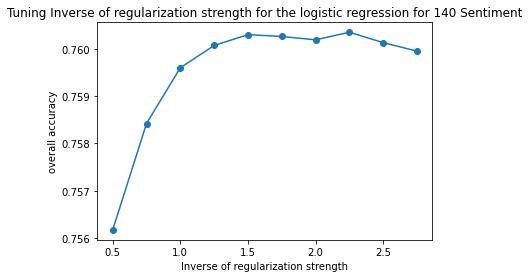

The best C: 2.25 with accuracy of: 0.76035


In [19]:
score=[]
cs=list(np.arange(0.5,3,0.25))
for c in cs:
    print("\n\nC:", c, "\n\n")
    clf = LogisticRegression(C=c, multi_class='auto', solver='liblinear', max_iter=200, tol=1e-3)
    accuracy = kfoldCV(cropped_x, cropped_y.values, clf, n_folds=5, batch_size=20000)
    score.append(np.mean(accuracy))
    
plt.plot(cs, score, 'o-')
plt.title('Tuning Inverse of regularization strength for the logistic regression for 140 Sentiment')
plt.ylabel('overall accuracy')
plt.xlabel('Inverse of regularization strength')
plt.show()
print("The best C:",cs[np.argmax(score)],"with accuracy of:",max(score))
best_c_140=cs[np.argmax(score)]

##### Test different penalty function for logistic regression



Penalty: l1 



----------------- Fold 0 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 2 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "




Penalty: l2 



----------------- Fold 0 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 2 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "




Penalty: elasticnet 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


Penalty: none 



----------------- Fold 0 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 2 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


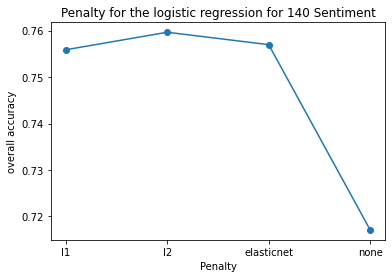

The best penalty: l2 with accuracy of: 0.75965


In [20]:
score=[]
cs=["l1","l2", "elasticnet","none"]
for c in cs:
    print("\n\nPenalty:", c, "\n\n")
    clf = LogisticRegression(C=1.0, multi_class='auto', solver='saga', penalty=c,max_iter=200, tol=1e-3, l1_ratio=0.5)
    accuracy= kfoldCV(cropped_x, cropped_y.values, clf, n_folds=5, batch_size=20000)
    score.append(np.mean(accuracy))
    
plt.plot(cs, score, 'o-')
plt.title('Penalty for the logistic regression for 140 Sentiment')
plt.ylabel('overall accuracy')
plt.xlabel('Penalty')
plt.show()
print("The best penalty:",cs[np.argmax(score)],"with accuracy of:",max(score))
best_penalty_140=cs[np.argmax(score)]

Training set variation

xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)
xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)
xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)
xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)
xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)
xt.shape: (358, 81577)
log_prior.shape: (2, 1)
self.sigma.shape: (2, 1, 81577)
self.mu.shape (2, 1, 81577)
xt.shape: (1, 358, 81577)
log_posterior.shape: (2, 358)


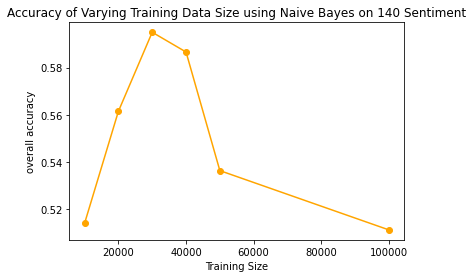

The best split: 30000 with accuracy of: 0.5949720670391061


In [21]:
score = []
data_split = [10000, 20000, 30000, 40000, 50000, 100000]
model = GaussianNaiveBayes()

for split in data_split:
    
    x_train_split, y_train_split  = cropped_x[:split], cropped_y.values[:split]
    model.fit(x_train_split, y_train_split)
    
    y_prob = model.predict(X_test_tf)

    y_pred = np.argmax(y_prob, 1)
    accuracy = evaluate_acc(y_pred,Y_test)
    score.append(accuracy)

plt.plot(data_split, score, 'o-', markerfacecolor='orange', color='orange')
plt.title('Accuracy of Varying Training Data Size using Naive Bayes on 140 Sentiment')
plt.ylabel('overall accuracy')
plt.xlabel('Training Size')
plt.show()
print("The best split:",data_split[np.argmax(score)],"with accuracy of:",max(score))

/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio p

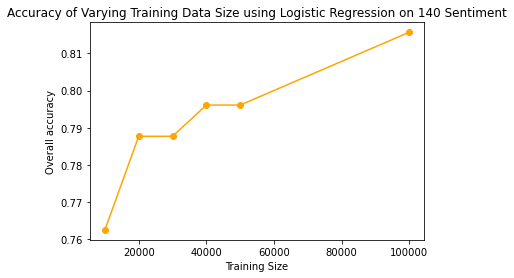

The best split: 100000 with accuracy of: 0.8156424581005587


In [22]:
score = []
data_split = [10000, 20000, 30000, 40000, 50000, 100000]

for split in data_split:
    
    x_train_split, y_train_split  = cropped_x[:split], cropped_y.values[:split]
    clf = LogisticRegression(C=best_c_140, multi_class='auto', solver='saga', penalty=best_penalty_140 ,max_iter=200, tol=1e-3, l1_ratio=0.5)
    clf.fit(x_train_split, y_train_split)
    accuracy = evaluate_acc(clf.predict(X_test_tf), Y_test)
    score.append(accuracy)

plt.plot(data_split, score, 'o-', markerfacecolor='orange', color='orange')
plt.title('Accuracy of Varying Training Data Size using Logistic Regression on 140 Sentiment')
plt.ylabel('Overall accuracy')
plt.xlabel('Training Size')
plt.show()
print("The best split:",data_split[np.argmax(score)],"with accuracy of:",max(score))


### Initial test with 20 News Group dataset




#### Naive Bayes implementation

In [23]:
model = GaussianNaiveBayes()

# split test data in two
accuracies=kfoldCV(x_twenty_train, y_twenty_train, model, n_folds=5)
print("\n\nMean Accuracy", np.mean(accuracies))


----------------- Fold 0 -----------------
----------- Batch 0 -----------
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
----------- Batch 1 -----------
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
----------- Batch 2 -----------
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
----------- Batch 3 -----------
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)

----------------- Fold 1 -----------------
----------- Batch 0 -----------
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
sel

In [24]:
accuracies

[0.6305, 0.6135, 0.6215, 0.6345, 0.636]

#### Softmax

##### Test regularization strenght softmax



C: 0.5 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


C: 0.75 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


C: 1.0 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
-------

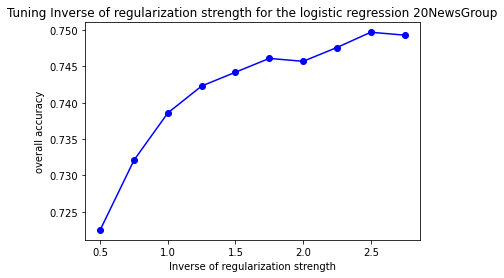

The best C: 2.5 with accuracy of: 0.7497


In [25]:
score=[]
cs=list(np.arange(0.5,3,0.25))
for c in cs:
    print("\n\nC:", c, "\n\n")
    clf = LogisticRegression(C=c, multi_class='auto', solver='liblinear', max_iter=200, tol=1e-3)
    accuracy=kfoldCV(x_twenty_train, y_twenty_train, clf, n_folds=5, batch_size=5000)
    score.append(np.mean(accuracy))
    
plt.plot(cs, score, 'o-', markerfacecolor='blue', color='blue')
plt.title('Tuning Inverse of regularization strength for the logistic regression 20NewsGroup')
plt.ylabel('overall accuracy')
plt.xlabel('Inverse of regularization strength')
plt.show()
print("The best C:",cs[np.argmax(score)],"with accuracy of:",max(score))
best_c_20=cs[np.argmax(score)]

##### Test different penalty function softmax



Penalty: l1 



----------------- Fold 0 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "




Penalty: l2 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 2 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "




Penalty: elasticnet 



----------------- Fold 0 -----------------
----------- Batch 0 -----------

----------------- Fold 1 -----------------
----------- Batch 0 -----------

----------------- Fold 2 -----------------
----------- Batch 0 -----------

----------------- Fold 3 -----------------
----------- Batch 0 -----------

----------------- Fold 4 -----------------
----------- Batch 0 -----------


Penalty: none 



----------------- Fold 0 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



----------------- Fold 1 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



----------------- Fold 2 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



----------------- Fold 3 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



----------------- Fold 4 -----------------
----------- Batch 0 -----------


/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


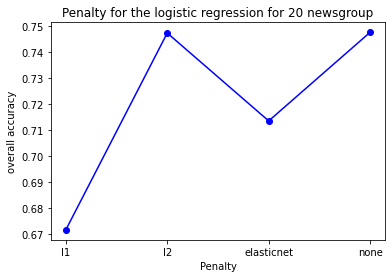

The best penalty: none with accuracy of: 0.7475


In [26]:
score=[]
cs=["l1","l2", "elasticnet",'none' ]
for c in cs:
    print("\n\nPenalty:", c, "\n\n")
    clf = LogisticRegression(C=2.0, multi_class='auto', solver='saga', penalty=c,max_iter=200, tol=1e-3, l1_ratio=0.5)
    accuracy=kfoldCV(x_twenty_train, y_twenty_train, clf, n_folds=5, batch_size=5000)

    score.append(np.mean(accuracy))
    
plt.plot(cs, score, 'o-', markerfacecolor='blue', color='blue')
plt.title('Penalty for the logistic regression for 20 newsgroup')
plt.ylabel('overall accuracy')
plt.xlabel('Penalty')
plt.show()
print("The best penalty:",cs[np.argmax(score)],"with accuracy of:",max(score))
best_penalty_20=cs[np.argmax(score)]

#### Training Set Variation
Naive Bayes:

xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
xt.shape: (814, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 814, 39115)
log_posterior.shape: (20, 814)
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
xt.shape: (814, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 814, 39115)
log_posterior.shape: (20, 814)
xt.shape: (500, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 500, 39115)
log_posterior.shape: (20, 500)
xt.shape: (814, 39115)
log_prior.shape: (20, 1)
self.sigma.shape: (20, 1, 39115)
self.mu.shape (20, 1, 39115)
xt.shape: (1, 814, 39115)
log_posterior.shape: (20, 814

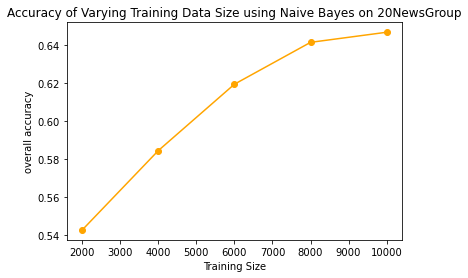

The best split: 10000 with accuracy of: 0.6468797564687976


In [27]:
score = []
data_split = [2000, 4000, 6000, 8000, 10000]
model = GaussianNaiveBayes()

for split in data_split:
    x_twenty_train_split, y_twenty_train_split = x_twenty_train[:split], y_twenty_train[:split]

    # split test data in two
    model.fit(x_twenty_train_split, y_twenty_train_split)
    x_twenty_test1 = x_twenty_test[:500]
    y_prob1 = model.predict(x_twenty_test1)

    model.fit(x_twenty_train_split, y_twenty_train_split)
    x_twenty_test2= x_twenty_test[500:]
    y_prob2 = model.predict(x_twenty_test2)

    y_prob = np.append(y_prob1, y_prob2, axis=0)
    y_pred = np.argmax(y_prob, 1)
    accuracy = np.sum(y_pred == y_twenty_test)/y_pred.shape[0]
    score.append(accuracy)

plt.plot(data_split, score, 'o-', markerfacecolor='orange', color='orange')
plt.title('Accuracy of Varying Training Data Size using Naive Bayes on 20NewsGroup')
plt.ylabel('overall accuracy')
plt.xlabel('Training Size')
plt.show()
print("The best split:",data_split[np.argmax(score)],"with accuracy of:",max(score))

Softmax regression:

/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/KarlKoerich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_l

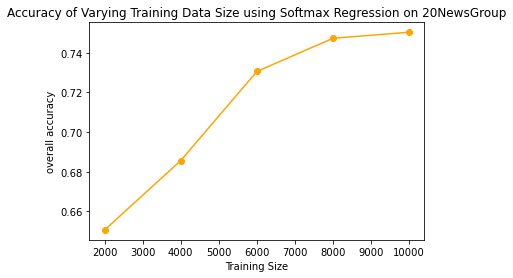

The best split: 10000 with accuracy of: 0.7503805175038052


In [28]:
score = []
data_split = [2000, 4000, 6000, 8000, 10000]

for split in data_split:
    x_twenty_train_split, y_twenty_train_split = x_twenty_train[:split], y_twenty_train[:split]

    clf = LogisticRegression(C=best_c_20, multi_class='auto', solver='saga', penalty=best_penalty_20,max_iter=200, tol=1e-3, l1_ratio=0.5)
    clf.fit(x_twenty_train_split, y_twenty_train_split)
    accuracy=evaluate_acc(clf.predict(x_twenty_test), y_twenty_test)

    score.append(accuracy)

plt.plot(data_split, score, 'o-', markerfacecolor='orange', color='orange')
plt.title('Accuracy of Varying Training Data Size using Softmax Regression on 20NewsGroup')
plt.ylabel('overall accuracy')
plt.xlabel('Training Size')
plt.show()
print("The best split:",data_split[np.argmax(score)],"with accuracy of:",max(score))